In [ ]:
# These commands download the MNIST dataset and a python package to read the data
!wget http://www.ivan-sipiran.com/downloads/mnist.zip
!unzip mnist.zip

--2025-09-26 17:43:50--  http://www.ivan-sipiran.com/downloads/mnist.zip
Resolving www.ivan-sipiran.com (www.ivan-sipiran.com)... 66.96.149.31
Connecting to www.ivan-sipiran.com (www.ivan-sipiran.com)|66.96.149.31|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3556 (3.5K) [application/zip]
Saving to: ‘mnist.zip’

mnist.zip           100%[===================>]   3.47K  --.-KB/s    in 0s      

2025-09-26 17:43:50 (296 MB/s) - ‘mnist.zip’ saved [3556/3556]

Archive:  mnist.zip
   creating: mnist/
  inflating: mnist/__init__.py       
   creating: mnist/__pycache__/
  inflating: mnist/__pycache__/__init__.cpython-38.pyc  


MNIST es un conjunto de datos de digitos escritos a mano.

Contiene 60,000 muestras para entrenamiento y 10,000 muestras para pruebas. Cada imagen es representada por píxeles de 28x28, cada uno contiene un valor entre 0 - 255 con su valor en escala de grises.

https://www.nvidia.com/en-us/glossary/pytorch/

In [ ]:
#Packages to use pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

#Packages to data management
from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold

import matplotlib.pyplot as plt
import numpy as np
import copy
import random
import time
import mnist #This is our package to handle MNIST

In [ ]:
#We explicitly set the random seed in order to get the same results in each run
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

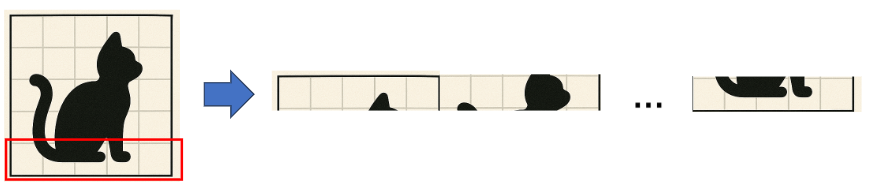

In [ ]:
#Load data
train_data = mnist.train_images() # Imagenes de tamaño 28 x 28
train_labels = mnist.train_labels()

test_data = mnist.test_images()
test_labels = mnist.test_labels()

#print(train_labels, test_labels)

#Convert data to vector representation
## Later on we will be using a MLP, which expects a feature vector.
## Allows common operations such as dot product and matrix multiplication.
## Before: (N, 28, 28), After: (N, 784)
train_data = train_data.reshape((train_data.shape[0], 784))
test_data = test_data.reshape((test_data.shape[0], 784))

#Compute the mean and standard deviation of the dataset
## Used to standardize the data
mean = train_data.astype(np.float32).mean()/255
std = train_data.astype(np.float32).std()/255

print(mean)
print(std)

#Normalize data
train_data = (train_data.astype(np.float32) - mean)/std
test_data = (test_data.astype(np.float32) - mean)/std

#Pack data with labels
train_data = list(zip(train_data, train_labels))
test_data = list(zip(test_data, test_labels))

print(len(train_data))
print(len(test_data))


- Download progress: 100%
Download finished.
- Download progress: 100%
Download finished.
- Download progress: 100%
Download finished.
- Download progress: 100%
Download finished.
0.13066058
0.3081076
60000
10000


In [ ]:
#Function to plot images in a matrix layout
def plot_images(images):
  num_images = len(images)

  rows = int(np.sqrt(num_images))
  cols = int(np.sqrt(num_images))

  fig = plt.figure()

  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    ax.imshow(images[i].reshape((28,28)), cmap='bone')
    ax.axis('off')

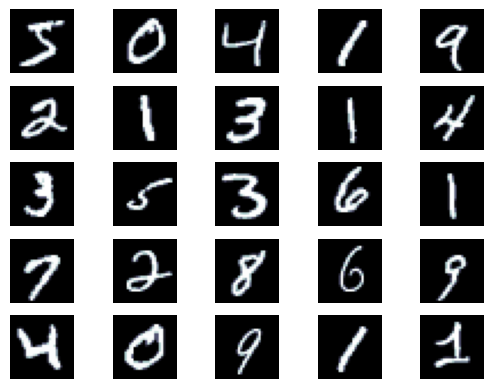

In [ ]:
#Plot images
N_IMAGES = 25

images = [image for image, labels in [train_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
#Split train data into TRAIN + VALIDATION (10% of the data as validation)
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

print(f'Num. training examples: {len(train_data)}')
print(f'Num. validation examples: {len(valid_data)}')
print(f'Num. testing examples: {len(test_data)}')


Num. training examples: 54000
Num. validation examples: 6000
Num. testing examples: 10000


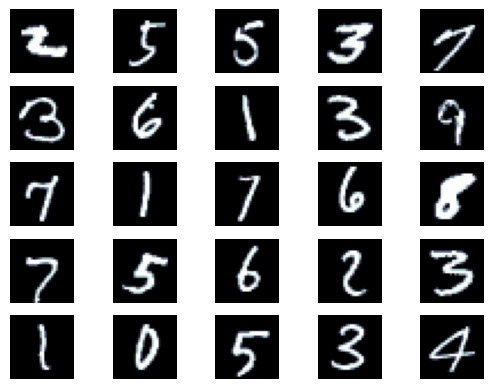

In [ ]:
#Plot validation data
N_IMAGES = 25

images = [image for image, labels in [valid_data[i] for i in range(N_IMAGES)]]

plot_images(images)

In [ ]:
#Pytorch has a nice feature to prepare data. The DataLoader creates an iterator of batches which are very convenient for training
#Set the batch size the biggest value as possible depending on your GPU. Operations in a batch are parallelized.
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

print(len(train_iterator))
print(len(valid_iterator))
print(len(test_iterator))

844
94
157


In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
#Class for our neural network. When a class inherits from torch.nn.Module,
#it automatically becomes a neural network

class MLP(nn.Module):
  # We need to define two methods at leats: constructor and forward

  #Constructor is for member definitions
  def __init__(self, input_dim, output_dim):
    super().__init__()

    # W*x + b
    self.fc1 = nn.Linear(input_dim, 250) # 784 x 250 + 250 (bias: extra parameters)
    self.fc2 = nn.Linear(250, 100) # 250 x 100 + 100
    self.fc3 = nn.Linear(100, output_dim) # 100 x 10 + 10

  #Forward: what happens when we feed the network with data
  def forward(self, input):
    batch_size = input.shape[0]
    #Flatten the input
    input = input.view(batch_size, -1)

    #Use ReLU as activation function
    h_1 = F.relu(self.fc1(input))
    h_2 = F.relu(self.fc2(h_1))
    y_pred = self.fc3(h_2)

    #Our network returns the output of the final layer but also the output of the hidden layer
    return y_pred, h_2

In [ ]:
# Create the model
INPUT_DIM = 28*28 # 784
OUTPUT_DIM = 10

model = MLP(INPUT_DIM, OUTPUT_DIM)

In [ ]:
#How many parameters are there in our model?

def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 222,360 trainable parameters


In [ ]:
#Create the object for the optimization.
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [ ]:
#Define the loss criterion
#In Pytorch, the CrossEntropyLoss includes the softmax activation and the negative log-likelihood cost function
#These two functions are joined because efficiency issues

criterion = nn.CrossEntropyLoss()

In [ ]:
#In Pytorch we can decide where to run our program, so we can
#initialize the device depending whether you have a GPU or not

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
#Send the model and the loss object to the GPU

model = model.to(device)
criterion = criterion.to(device)

In [ ]:
#Function to compute the accuracy. We assume the predictions and the labels are tensors in the GPU

def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim=True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float()/y.shape[0]
  return acc


In [ ]:
#Define a function to perform training

def train(model, iterator, optimizer, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We have to set the neural network in training mode. This is because during
  #training, we need gradients and complementary data to ease the computation
  model.train()

  #Training loop
  for (x, y) in iterator:
    x = x.to(device) #Data
    y = y.long().to(device) #Labels

    optimizer.zero_grad() #Clean gradients

    y_pred, _ = model(x) #Feed the network with data

    loss = criterion(y_pred, y) #Compute the loss

    acc = calculate_accuracy(y_pred, y) #Compute the accuracy

    loss.backward() #Compute gradients

    optimizer.step() #Apply update rules

    epoch_loss += loss.item()
    epoch_acc += acc.item()

  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
#Function to test neural network

def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0

  #We put the network in testing mode
  #In this mode, Pytorch doesn't use features only reserved for
  #training (dropout for instance)
  model.eval()

  with torch.no_grad(): #disable the autograd engine (save computation and memory)

    for (x, y) in iterator:
      x = x.to(device)
      y = y.long().to(device)

      y_pred, _ = model(x)

      loss = criterion(y_pred, y)

      acc = calculate_accuracy(y_pred, y)

      epoch_loss += loss.item()
      epoch_acc += acc.item()
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
#Let's perform the training

EPOCHS = 30

best_valid_loss = float('inf')

train_losses, valid_losses = [], []
train_accs, valid_accs = [], []

for epoch in range(EPOCHS):

  start_time = time.time()

  #Train + validation cycles
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  # guardar métricas
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)
  train_accs.append(train_acc)
  valid_accs.append(valid_acc)

  #If we find a smaller loss, we save the model
  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    torch.save(model.state_dict(), 'saved-model.pt')

  end_time = time.time()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)

  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 2s
	Train Loss: 0.668 | Train Acc: 87.11%
	 Val. Loss: 0.280 |  Val. Acc: 91.65%
Epoch: 02 | Epoch Time: 0m 1s
	Train Loss: 0.198 | Train Acc: 94.05%
	 Val. Loss: 0.230 |  Val. Acc: 92.66%
Epoch: 03 | Epoch Time: 0m 1s
	Train Loss: 0.139 | Train Acc: 95.71%
	 Val. Loss: 0.206 |  Val. Acc: 94.46%
Epoch: 04 | Epoch Time: 0m 1s
	Train Loss: 0.106 | Train Acc: 96.76%
	 Val. Loss: 0.176 |  Val. Acc: 95.08%
Epoch: 05 | Epoch Time: 0m 1s
	Train Loss: 0.084 | Train Acc: 97.38%
	 Val. Loss: 0.170 |  Val. Acc: 95.24%
Epoch: 06 | Epoch Time: 0m 1s
	Train Loss: 0.068 | Train Acc: 97.92%
	 Val. Loss: 0.160 |  Val. Acc: 95.67%
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.056 | Train Acc: 98.29%
	 Val. Loss: 0.164 |  Val. Acc: 95.78%
Epoch: 08 | Epoch Time: 0m 1s
	Train Loss: 0.046 | Train Acc: 98.62%
	 Val. Loss: 0.157 |  Val. Acc: 95.69%
Epoch: 09 | Epoch Time: 0m 1s
	Train Loss: 0.038 | Train Acc: 98.88%
	 Val. Loss: 0.159 |  Val. Acc: 96.05%
Epoch: 10 | Epoch Time: 0m 1

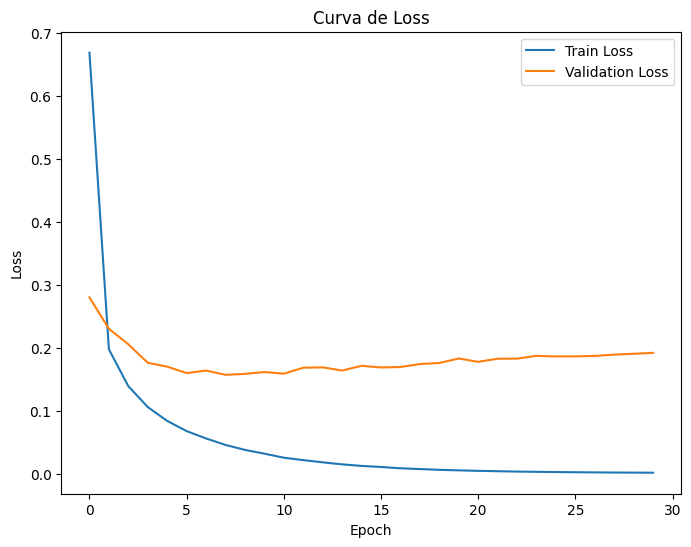

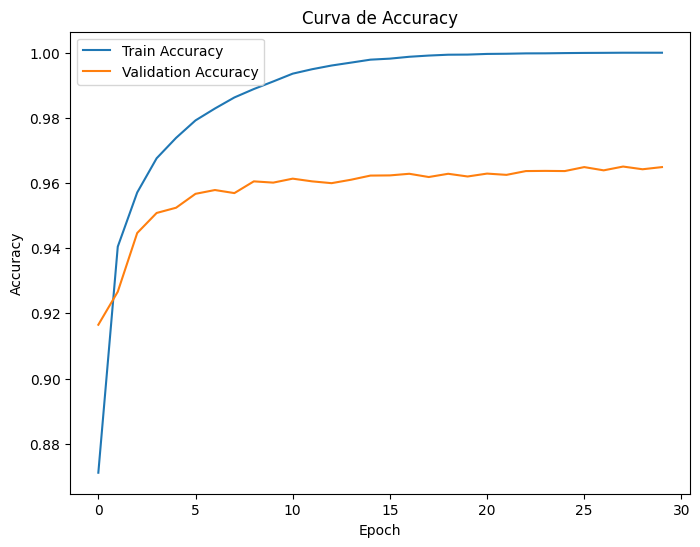

In [ ]:
import matplotlib.pyplot as plt

# Curvas de pérdida
plt.figure(figsize=(8,6))
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Curva de Loss')
plt.legend()
plt.show()

# Curvas de accuracy
plt.figure(figsize=(8,6))
plt.plot(train_accs, label='Train Accuracy')
plt.plot(valid_accs, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Curva de Accuracy')
plt.legend()
plt.show()

In [ ]:
#Load the best model
model.load_state_dict(torch.load('saved-model.pt'))

test_loss , test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.154 | Test Acc: 95.77%


In [ ]:
#Function to get predictions over a dataset

def get_predictions(model, iterator, device):

    #For prediction, we also deactivate training features
    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        # x: batch de imágenes
        # y: etiquetas reales
        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x)

            #Remember that our network does not apply the softmax (takes the vector ouput
            # and convert then into probabilities, per class)
            #We have to do it explicitly for prediction
            y_prob = F.softmax(y_pred, dim = -1)
            top_pred = y_prob.argmax(1, keepdim = True)

            #We store the images, their labels and the pdf of each sample
            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim = 0)
    labels = torch.cat(labels, dim = 0)
    probs = torch.cat(probs, dim = 0)

    # imágenes procesadas, etiquetas reales, probabilidades predichas
    return images, labels, probs

In [ ]:
#Comute predictions and the label with the maximum probability
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

pred_labels

tensor([7, 2, 1,  ..., 4, 5, 6])

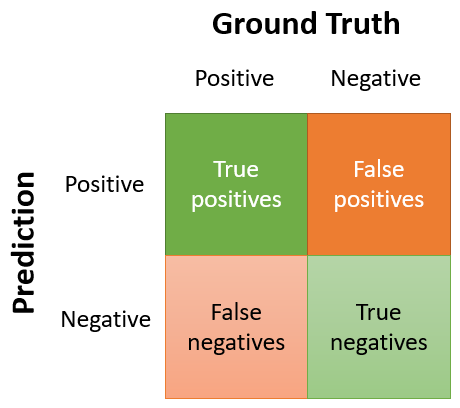

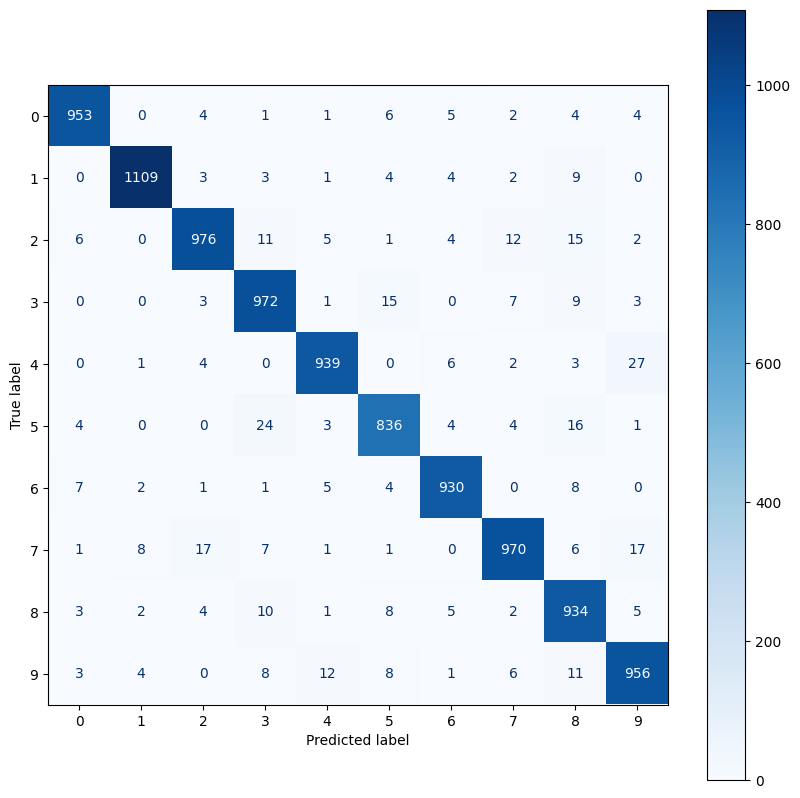

In [ ]:
#Plot a confussion matrix
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize = (10, 10));
    ax = fig.add_subplot(1, 1, 1);
    cm = metrics.confusion_matrix(labels, pred_labels);
    cm = metrics.ConfusionMatrixDisplay(cm);
    cm.plot(values_format = 'd', cmap = 'Blues', ax = ax)

plot_confusion_matrix(labels, pred_labels)

In [ ]:
#Number of correct predictions
#Remember labels and predictions are tensors in GPU
corrects = torch.eq(labels, pred_labels)

In [ ]:
#Collect the incorrect predictions
incorrect_examples = []

# La probabilidad también puede representar un grado de confianza,
# por lo que ordenamos las muestras incorrectas utilizando ese nivel de confianza
for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

#We want to know the samples in which the neural network is sure the prediction was perfect
incorrect_examples.sort(reverse = True, key = lambda x: torch.max(x[2], dim = 0).values)

In [ ]:
# Grafica una cuadricula con las imágenes mal clasificadas por el modelo
def plot_most_incorrect(incorrect, n_images):

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (20, 10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        image, true_label, probs = incorrect[i]
        true_prob = probs[true_label.item()]
        incorrect_prob, incorrect_label = torch.max(probs, dim = 0) # Aqui asigna la probabilidad predicha
        ax.imshow(image.view(28, 28).cpu().numpy(), cmap='bone')
        ax.set_title(f'true label: {true_label} ({true_prob:.2f})\n' \
                     f'pred label: {incorrect_label} ({incorrect_prob:.2f})')
        ax.axis('off')
    fig.subplots_adjust(hspace= 0.5)

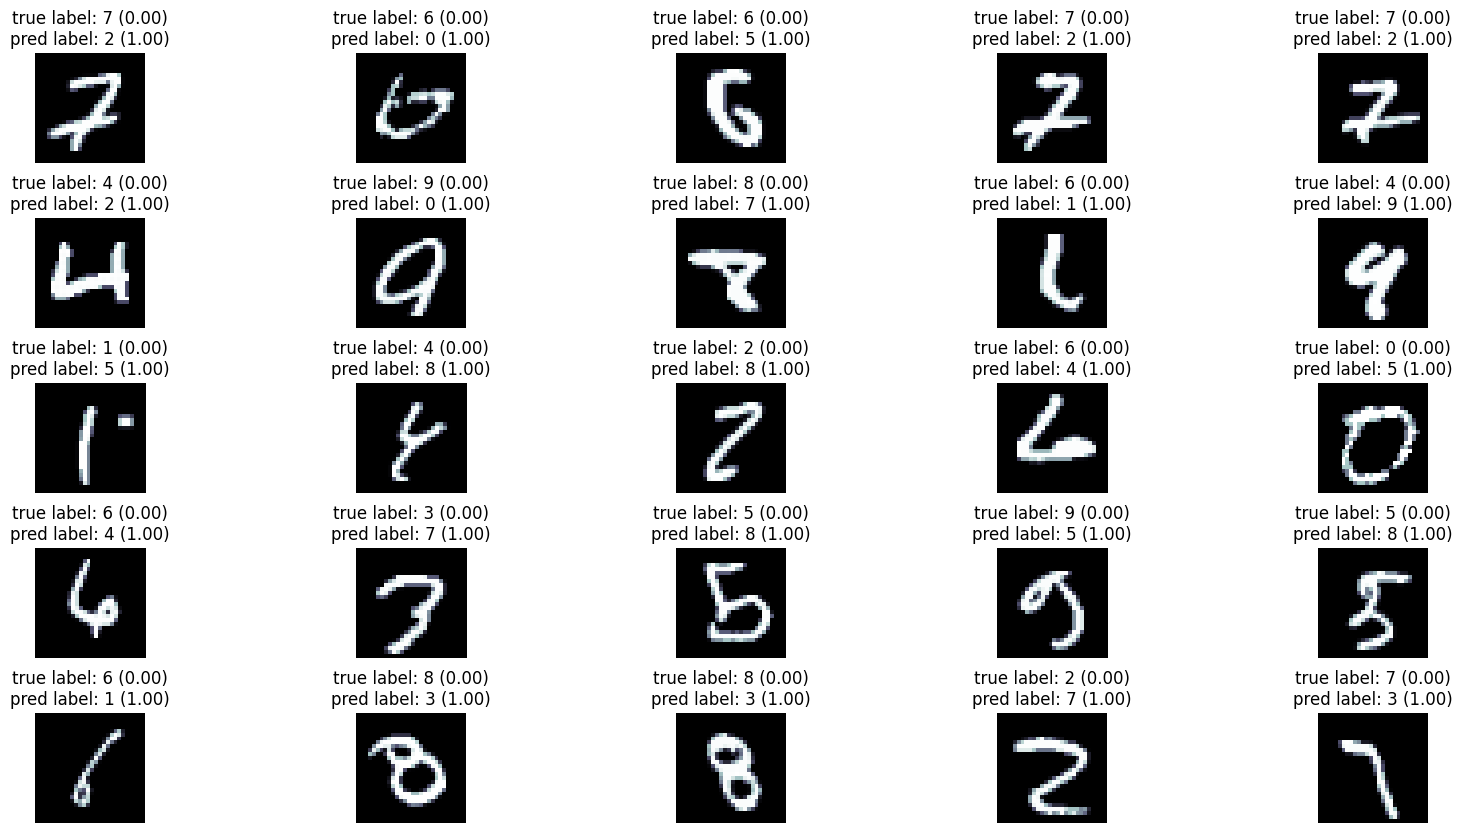

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

In [ ]:
#Function to compute the prediction and the intermediate representation of images
def get_representations(model, iterator, device):

    model.eval()

    outputs = []
    intermediates = []
    labels = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, h = model(x) #y_pred: salida final antes de softmax (dimensión 10), h: vector de la penúltima capa (dimensión 100)

            #We will register the output + output of hidden layer per image
            outputs.append(y_pred.cpu())
            intermediates.append(h.cpu())
            labels.append(y)

    outputs = torch.cat(outputs, dim = 0)
    intermediates = torch.cat(intermediates, dim = 0)
    labels = torch.cat(labels, dim = 0)

    # Obtiene las predicciones y representaciones internas del modelo para cada imagen.
    return outputs, intermediates, labels

#Function to reduce the dimensionality of data to dimension 2
def get_pca(data, n_components = 2):
    pca = decomposition.PCA()
    pca.n_components = n_components
    pca_data = pca.fit_transform(data)
    return pca_data

#Plot 2D representation
def plot_representations(data, labels, n_images = None):
    if n_images is not None:
        data = data[:n_images]
        labels = labels[:n_images]
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111)
    scatter = ax.scatter(data[:, 0], data[:, 1], c = labels, cmap = 'tab10')
    legend = ax.legend(*scatter.legend_elements())
    ax.add_artist(legend)


Aplicaremos dos técnicas de reducción de dimensionalidad (PCA y t-SNE).

> Relación lineal: los cambios en una variables están relacionados de manera proporcional y pueden representarse como una recta en un gráfico 2D.

PCA:
* Método lineal que proyecta los datos en un nuevo espacio de coordenadas.
* Asume que los datos se pueden representar como combinaciones lineales de las variables originales.
* Permite interpretar qué variables influyen más en cada componente.
* Ventajas:
  * Rápido y computacionalmente eficiente.
  * Bueno para datos de alta dimensión con relaciones lineales.
  * Útil para preprocesamiento antes de entrenar modelos.
* Desventajas:
  * No captura relaciones no lineales.
  * Los componentes no siempre son fáciles de interpretar.

t-SNE:
* Método no lineal que busca preservar la estructura local ed los datos.
* Ventajas:
  * Útil para visualizar clústeres en datos complejos.
  * Preserva relaciones locales entre los datos.
* Desventajas:
  * Computacionalmente más caro.
  * No es adeucado para preprocesamiento, es más bien para exploración y visualización.

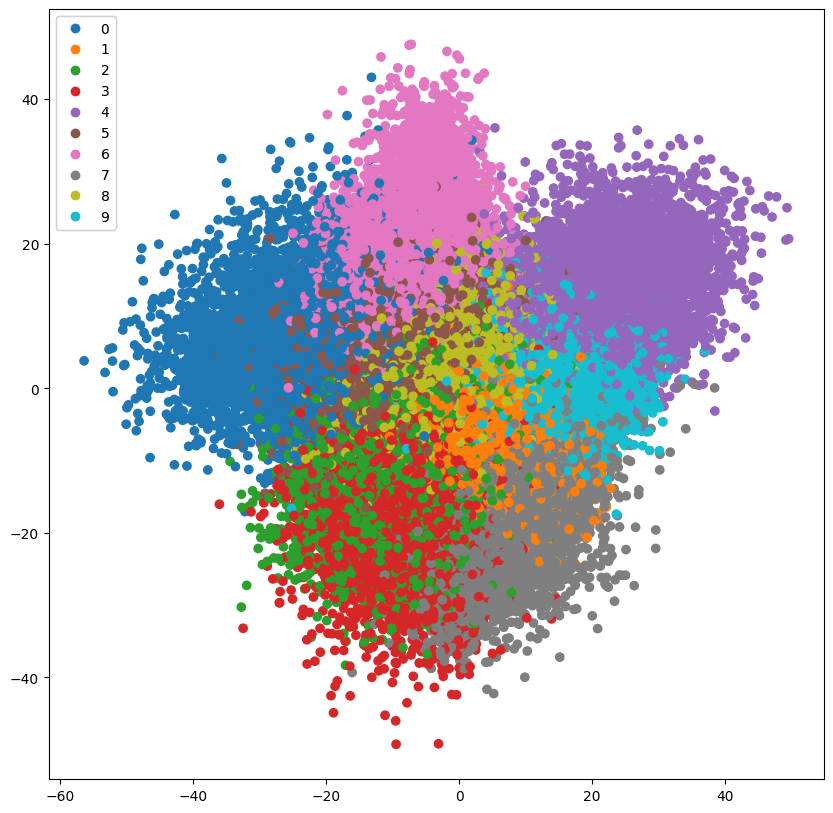

In [ ]:
#Let's see the representation of the output
outputs, intermediates, labels = get_representations(model, train_iterator, device)
output_pca_data = get_pca(outputs)
plot_representations(output_pca_data, labels)


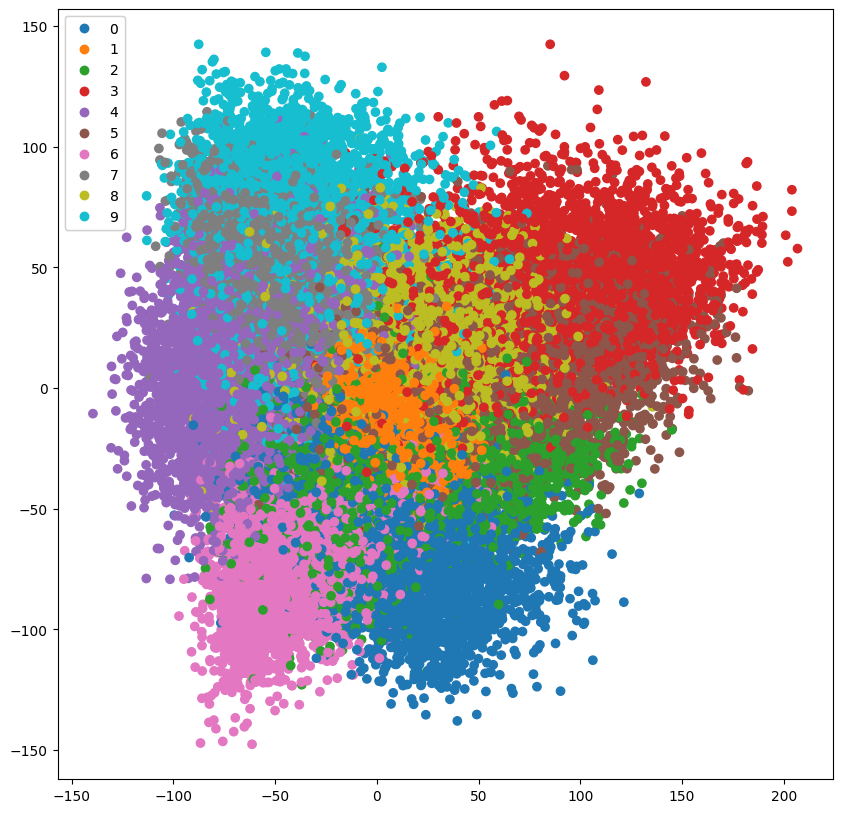

In [ ]:
#ow, let's see the representation of the hidden layer
intermediate_pca_data = get_pca(intermediates)
plot_representations(intermediate_pca_data, labels)

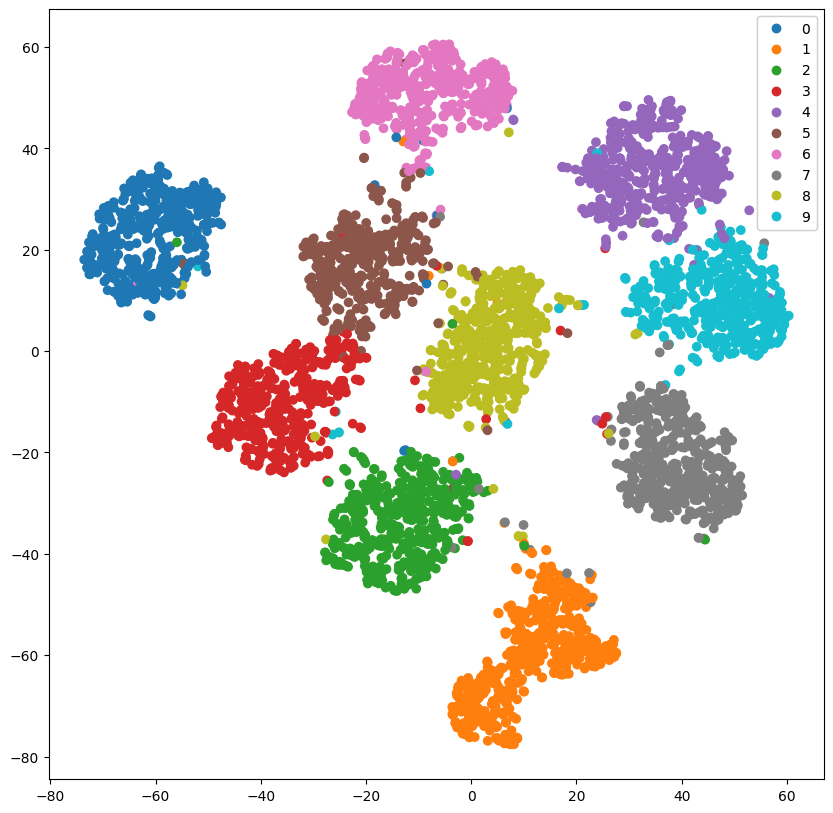

In [ ]:
#We will use a different tool: t-SNE
def get_tsne(data, n_components = 2, n_images = None):
    if n_images is not None:
        data = data[:n_images]
    tsne = manifold.TSNE(n_components = n_components, random_state = 0)
    tsne_data = tsne.fit_transform(data)
    return tsne_data

#t-SNE is computationally expensive, we only apply it on 5000 images
N_IMAGES = 5_000

output_tsne_data = get_tsne(outputs, n_images = N_IMAGES)
plot_representations(output_tsne_data, labels, n_images = N_IMAGES)

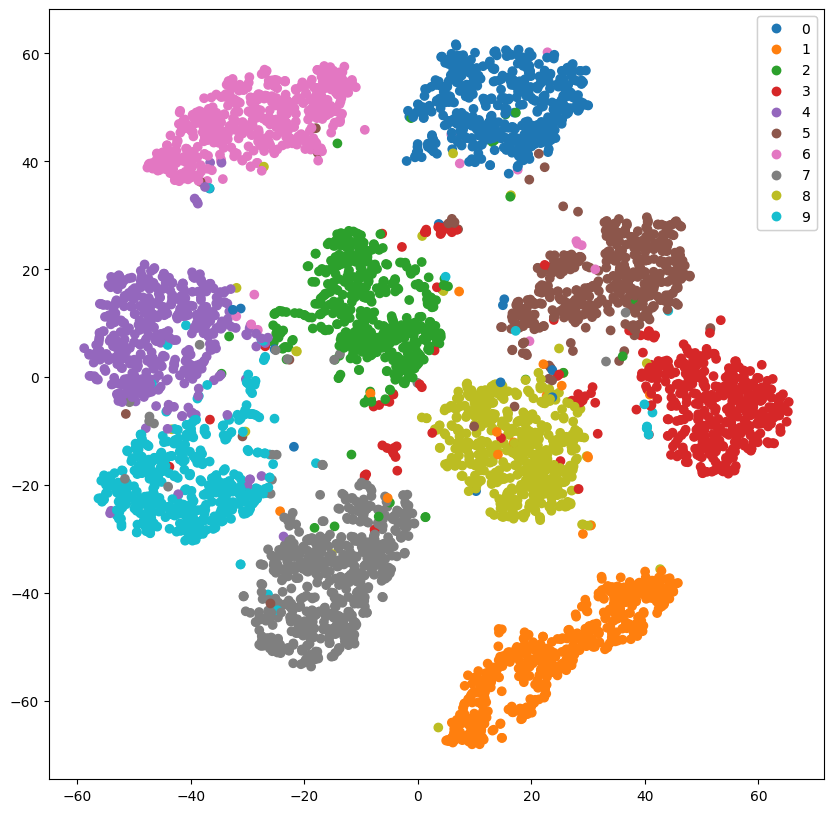

In [ ]:
intermediate_tsne_data = get_tsne(intermediates, n_images = N_IMAGES)
plot_representations(intermediate_tsne_data, labels, n_images = N_IMAGES)